In [1]:
import numpy as np
import pandas as pd
import os
import glob
import json # for reading annotations from json
from tqdm import tqdm
import random
import math
from PIL import Image,ImageDraw
import tensorflow as tf
from collections import Counter 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.nn import functional as F
from torchvision import transforms as T
from torch import optim
import yaml
import argparse
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay

# import h5py
# !pip install torchsummary
# from torchsummary import summary

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.datasets import ImageFolder
# !pip install einops
# import einops

2024-04-29 15:24:53.697062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 15:24:53.697173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 15:24:53.827956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
class Params:
    im_path='/kaggle/input/celebatext/CelebA-HQ-img/'
    annot_path='/kaggle/input/celebatext/celeba-caption/'
    vqvae_ckpt='/kaggle/input/vqvae_ckpt/pytorch/vqvae_ckpt_celeba/1/ver1.pth'
    im_size=256
    temb_dim=512
    batch_size=4
    text_model='bert'
    lr=5e-06
    num_epochs=5
    num_timesteps=1000
    beta_start=0.00085
    beta_end=0.012
    cf_guidance_scale=0.75
    # UNET
    in_channels=3
    conv_out_channels=128
    norm_channels=32
    num_heads=8
    text_embed_dim=768
    down_blocks=[256, 384, 512, 768]
    mid_blocks=[768,512]
    up_blocks=[768*2,512*2,384,64]
    num_layers=2

hp=Params()

In [5]:
## this function is used to retrieve encoded tokenized text data
import torch
from transformers import DistilBertModel, DistilBertTokenizer, CLIPTokenizer, CLIPTextModel

def get_tokenizer_and_model(model_type, device, eval_mode=True):
    assert model_type in ('bert', 'clip'), "Text model can only be one of clip or bert"
    if model_type == 'bert':
        text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        text_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
    else:
        text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
        text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)
    if eval_mode:   
        text_model.eval()
    return text_tokenizer, text_model
   

# data_transforms = T.Compose([
#     T.Resize(im_size),
#     T.CenterCrop(im_size),
#     T.ToTensor(),
#     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

class Util:
    def __init__(self,model:str):
        self.device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        self.text_tokenizer,self.text_model=get_tokenizer_and_model(model,self.device)
        

    def get_text_representation(self,text,
                                truncation=True,
                                padding='max_length',
                                max_length=77):
        token_output = self.text_tokenizer(text,
                                      truncation=truncation,
                                      padding=padding,
                                      return_attention_mask=True,
                                      max_length=max_length)
        indexed_tokens = token_output['input_ids']
        att_masks = token_output['attention_mask']
        tokens_tensor = torch.tensor(indexed_tokens).to(self.device)
        mask_tensor = torch.tensor(att_masks).to(self.device)
        text_embed = self.text_model(tokens_tensor, attention_mask=mask_tensor).last_hidden_state
        return text_embed
        

    def get_time_embedding(self,time_steps, temb_dim):
        """
        Convert time steps tensor into an embedding using the
        sinusoidal time embedding formula
        :param time_steps: 1D tensor of length batch size
        :param temb_dim: Dimension of the embedding
        :return: BxD embedding representation of B time steps
        """
        assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
        # factor = 10000^(2i/d_model)
        factor = 10000 ** ((torch.arange(
            start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
        )
    
        # pos / factor
        # timesteps B -> B, 1 -> B, temb_dim
        t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
        t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
        return t_emb

util=Util(hp.text_model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import glob
from PIL import Image
from torchvision import transforms as T

# 'C:/Users/tarun/Downloads/Compressed/celeba_data/CelebA-HQ-img/*.jpg'



class CelebaDataset(Dataset):
    def __init__(self,im_path,annot_path,im_size,indices):
        self.im_path=im_path
        self.annot_path=annot_path
        self.indices=indices
        self.im_size=im_size
        
        self.images=glob.glob(im_path+'*.jpg')
        self.images+=glob.glob(im_path+'*.png')
        self.images+=glob.glob(im_path+'*.jpeg')
        
        for i in range(len(self.images)):
            self.images[i]=self.images[i].replace('\\','/')
        
        self.transforms=T.Compose([
                        T.Resize(self.im_size),
                        T.CenterCrop(self.im_size),
                        T.ToTensor(),
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx=self.indices[idx]
        im_path=self.images[idx]
        name=im_path.split('/')[-1][:-4]
        captions_im = []
        with open(self.annot_path+name+'.txt') as f:
            for line in f.readlines():
                captions_im.append(line.strip())
        img=Image.open(im_path).convert('RGB').resize((self.im_size,self.im_size))
        
        return self.transforms(img),captions_im[0]
    

unique_id=np.arange(0,30000)
threshold=int(unique_id.shape[0]*0.9)
train_id=unique_id[:threshold]
test_id=unique_id[threshold:]

train_dl=DataLoader(CelebaDataset(hp.im_path,hp.annot_path,hp.im_size,train_id),batch_size=hp.batch_size)
val_dl=DataLoader(CelebaDataset(hp.im_path,hp.annot_path,hp.im_size,test_id),batch_size=hp.batch_size)

# VQVAE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, ConvTranspose2d, GroupNorm, Sequential, MultiheadAttention, SiLU, Embedding

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.residual_input_conv = Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.down_sample_conv = Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        residual = self.residual_input_conv(x)
        x = self.resnet_conv_first(x)
        x = self.resnet_conv_second(x)
        x = F.silu(x + residual)
        x = self.down_sample_conv(x)
        return x

class MidBlock(nn.Module):
    def __init__(self, channels):
        super(MidBlock, self).__init__()
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )
        self.attention_norms = nn.GroupNorm(32, channels)
        self.attentions = nn.MultiheadAttention(embed_dim=channels, num_heads=2)
        self.residual_input_conv = Conv2d(channels, channels, kernel_size=1, stride=1)

    def forward(self, x):
        residual = self.residual_input_conv(x)
        x = self.resnet_conv_first(x)
        x = self.resnet_conv_second(x)
        x = F.silu(x + residual)
        B,C,H,W=x.shape
        residual=x
        x=x.reshape(B,C,H*W)
        x = self.attention_norms(x)
        x=x.transpose(1,2)
        x, _ = self.attentions(x, x, x)
        x=x.transpose(1,2).reshape(B,C,W,H)
        return x+residual

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.residual_input_conv = Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.up_sample_conv = ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        residual = self.residual_input_conv(x)
        x = self.resnet_conv_first(x)
        x = self.resnet_conv_second(x)
        x = F.silu(x + residual)
        x = self.up_sample_conv(x)
        return x

class VQVAE(nn.Module):
    def __init__(self, input_channels=3, codebook_size=8192):
        super(VQVAE, self).__init__()
        self.encoder_conv_in = Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.encoder_layers = nn.ModuleList([
            DownBlock(64, 128),
            DownBlock(128, 256),
            DownBlock(256, 256)
        ])
        self.encoder_mids = nn.ModuleList([
            MidBlock(256)
        ])
        self.encoder_norm_out = GroupNorm(32, 256)
        self.encoder_conv_out = Conv2d(256, input_channels, kernel_size=3, stride=1, padding=1)
        self.pre_quant_conv = Conv2d(input_channels, input_channels, kernel_size=1, stride=1)
        self.embedding = Embedding(codebook_size, input_channels)#this embedding_dim should match pre_quant_conv channels
        self.post_quant_conv = Conv2d(input_channels, 16, kernel_size=1, stride=1)
        self.decoder_conv_in = Conv2d(16, 256, kernel_size=3, stride=1, padding=1)
        self.decoder_mids = nn.ModuleList([
            MidBlock(256)
        ])
        self.decoder_layers = nn.ModuleList([
            UpBlock(256, 256),
            UpBlock(256, 128),
            UpBlock(128, 64)
        ])
        self.decoder_norm_out = GroupNorm(32, 64)
        self.decoder_conv_out = Conv2d(64, input_channels, kernel_size=3, stride=1, padding=1)

        
    
    def quantize(self, x):
        B, C, H, W = x.shape
        
        # B, C, H, W -> B, H, W, C
#         print(x.shape)
        x = x.permute(0, 2, 3, 1)
        
        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))
#         print(x.shape,self.embedding.weight.shape)
        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        
        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()
        
        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices
    
    
    def encode(self,x):
        x = self.encoder_conv_in(x)
        for layer in self.encoder_layers:
            x = layer(x)
        for layer in self.encoder_mids:
            x = layer(x)
        x = self.encoder_norm_out(x)
        x = self.encoder_conv_out(x)
        x = self.pre_quant_conv(x)
        out, quant_losses, _ = self.quantize(x)
        return out,quant_losses
    
    
    def decode(self,x):
        x=self.post_quant_conv(x)
        x = self.decoder_conv_in(x)
        for layer in self.decoder_mids:
            x = layer(x)
        for layer in self.decoder_layers:
            x = layer(x)
        x = self.decoder_norm_out(x)
        x = self.decoder_conv_out(x)
        return x
    
    def forward(self, x):
        # Encoder
        z,quant_losses=self.encode(x)
        # print('Encoding Completed',x.shape)
        
        # Decoder
        output=self.decode(z)
        
        return output,z,quant_losses


# UNET

In [8]:
import torch
import numpy as np


class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        # Mimicking how compvis repo creates schedule
        self.betas = (
                torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2
        )
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
    
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


def inference(diffusion,vqvae,scheduler,device):
    diffusion.eval().to(device)
    vqvae.eval().to(device)
    with torch.no_grad():
        xt = torch.randn((1,
                      hp.in_channels,
                      hp.im_size//8,
                      hp.im_size//8)).to(device)
        text_prompt = ['He is a man.']
        text_prompt_embed = util.get_text_representation(text_prompt).to(device)
        cf_guidance_scale = hp.cf_guidance_scale
        for i in (reversed(range(hp.num_timesteps))):
            t = (torch.ones((xt.shape[0],)) * i).long().to(device)
            t=util.get_time_embedding(t,hp.temb_dim).to(device)
            noise_pred_cond = diffusion(xt, t, text_prompt_embed)
            if cf_guidance_scale > 1:
                noise_pred_uncond = diffusion(xt, t, text_prompt_embed)
                noise_pred = noise_pred_uncond + cf_guidance_scale * (noise_pred_cond - noise_pred_uncond)
            else:
                noise_pred = noise_pred_cond
            xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
            if i == 0:
                # Decode ONLY the final iamge to save time
                ims = vqvae.decode(xt)
                img=torchvision.transforms.ToPILImage()(ims[0])
                plt.imshow(img)
                plt.show()
                img.save('sample1.png')
            else:
                ims = x0_pred
        

def train(diffusion,vqvae,dataloader,optimizer_diffusion,scheduler,device):
    criterion=nn.MSELoss()
    diffusion.train().to(device)
    vqvae.eval().to(device)
    losses=[]
    i=0
    for epoch in range(hp.num_epochs):
        for im,txt in tqdm(dataloader):
            txt=util.get_text_representation(txt)
            im,txt=im.to(device),txt.to(device)
            optimizer_diffusion.zero_grad()
            im,_=vqvae.encode(im)
            noise = torch.randn_like(im).to(device)
            t = torch.randint(0, hp.num_timesteps, (im.shape[0],)).to(device)
            noisy_im = scheduler.add_noise(im, noise, t)
            t=util.get_time_embedding(t,hp.temb_dim).to(device)
            noise_pred = diffusion(noisy_im, t, txt)
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
#             noise_pred=noise_pred.detach().cpu()
#             loss=loss.detach().cpu()
            optimizer_diffusion.step()
#             print(loss)
            
        print('Finished epoch:{} | Loss : {:.4f}'.format(epoch + 1,np.mean(losses)))
        torch.save(diffusion.state_dict(), 'diffusion.pth')
        inference(diffusion,vqvae,scheduler,device)

    



In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,temb_dim,layers,self_attention=False,cross_attention=False,context_dim=None):
        super(ResidualBlock, self).__init__()
        self.layers=layers
        self.temb_dim=temb_dim
        self.self_attention=self_attention
        self.cross_attention=cross_attention
        self.context_dim=context_dim
        
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
            nn.GroupNorm(hp.norm_channels, in_channels if i==0 else out_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels if i==0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
            for i in range(layers)
        ])
        
        self.temb_layers=nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(temb_dim,out_channels)
            )
            for _ in range(layers)
        ])
        
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
            nn.GroupNorm(hp.norm_channels, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )    
            for _ in range(layers)
        ])
        
        self.attn_norms=nn.ModuleList([
            nn.GroupNorm(hp.norm_channels,out_channels) for _ in range(layers)    
        ])
        self.attn=nn.ModuleList([
            nn.MultiheadAttention(out_channels,hp.num_heads,batch_first=True) for _ in range(layers)    
        ])
        
        self.cross_attn_norms=nn.ModuleList([
            nn.GroupNorm(hp.norm_channels,out_channels) for _ in range(layers)    
        ])
        self.cross_attn=nn.ModuleList([
            nn.MultiheadAttention(out_channels,hp.num_heads,batch_first=True) for _ in range(layers)    
        ])
        
        if self.context_dim is not None:
            self.context_proj=nn.ModuleList([
                nn.Linear(self.context_dim,out_channels) for _ in range(self.layers)    
            ])


        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels if i==0 else out_channels, out_channels, kernel_size=1, stride=1) for i in range(self.layers)  
        ])
      
    def forward(self, x, t_emb, context=None):
        # out : (B,C,H,W)
        # t_emb: (B,temb_dim)
        
        out=x
        for i in range(self.layers):
            resnet_input=out
            out=self.resnet_conv_first[i](out)
            out=out+self.temb_layers[i](t_emb).unsqueeze(-1).unsqueeze(-1)
            out=self.resnet_conv_second[i](out)
            out=out+self.residual_input_conv[i](resnet_input)
            
            if self.self_attention:
                B,C,H,W=out.shape
                in_attn=out.reshape(B,C,H*W)
                in_attn=self.attn_norms[i](in_attn)
                in_attn=in_attn.transpose(1,2)
                out_attn,_=self.attn[i](in_attn,in_attn,in_attn)
                out_attn=out_attn.transpose(1,2).reshape(B,C,H,W)
                out=out+out_attn
            
            if self.cross_attention:
                B,C,H,W=out.shape
                in_attn=out.reshape(B,C,H*W)
                in_attn=self.cross_attn_norms[i](in_attn)
                in_attn=in_attn.transpose(1,2)
                context_proj=self.context_proj[i](context)
                out_attn,_=self.cross_attn[i](in_attn,context_proj,context_proj)
                out_attn=out_attn.transpose(1,2).reshape(B,C,H,W)
                out=out+out_attn
                
        return out
    

class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_in=nn.Conv2d(hp.in_channels,hp.down_blocks[0],kernel_size=3,stride=1,padding=1)
        self.t_proj=nn.Sequential(
            nn.Linear(hp.temb_dim,hp.temb_dim),
            nn.SiLU(),
            nn.Linear(hp.temb_dim,hp.temb_dim)
        )

        self.downblock=nn.ModuleList([])
        for i in range(len(hp.down_blocks)-1):
            self.downblock.append(
                ResidualBlock(hp.down_blocks[i],hp.down_blocks[i+1],hp.temb_dim,hp.num_layers,True,True,hp.text_embed_dim)
            )
            self.downblock.append(nn.Conv2d(hp.down_blocks[i+1],hp.down_blocks[i+1],kernel_size=3,stride=2,padding=1))
            
        self.midblock=nn.ModuleList([])
        for i in range(len(hp.mid_blocks)-1):
            self.midblock.append(
                ResidualBlock(hp.mid_blocks[i],hp.mid_blocks[i+1],hp.temb_dim,hp.num_layers,True,True,hp.text_embed_dim)
            )
        
        # 2 1 0
        self.upblock=nn.ModuleList([])
        for i in reversed(range(len(hp.down_blocks) - 1)):
            self.upblock.append(nn.ConvTranspose2d(hp.down_blocks[i],hp.down_blocks[i],kernel_size=4,stride=2,padding=1))
            self.upblock.append(
                ResidualBlock(hp.down_blocks[i]*2,hp.down_blocks[i-1] if i!=0 else hp.conv_out_channels,hp.temb_dim,hp.num_layers,True,True,hp.text_embed_dim)
            )
            
            
        self.norm_out=nn.GroupNorm(hp.norm_channels,hp.conv_out_channels)
        self.silu=nn.SiLU()
        self.conv_out=nn.Conv2d(hp.conv_out_channels,3,kernel_size=3,stride=1,padding=1)
        

    def forward(self,x,t_emb,context):
        x=self.conv_in(x)
        t_emb=self.t_proj(t_emb)
        down_outs = []
        for layer in self.downblock:
            if isinstance(layer,ResidualBlock):
                down_outs.append(x)
                x=layer(x,t_emb,context)
            else:
                x=layer(x)
                
        for layer in self.midblock:
            if isinstance(layer,ResidualBlock):
                x=layer(x,t_emb,context)
            else:
                x=layer(x)
               
        for layer in self.upblock:
            if isinstance(layer,ResidualBlock):
                x=layer(x,t_emb,context)
            else:
                x=layer(x)
                out_down=down_outs.pop()
                x = torch.cat([x, out_down], dim=1)
            
            
        x=self.silu(self.norm_out(x))
        x=self.conv_out(x)
        return x
        
diffusion=UNET()

Model Weights Loaded


100%|██████████| 6750/6750 [35:03<00:00,  3.21it/s]


Finished epoch:1 | Loss : 0.1894


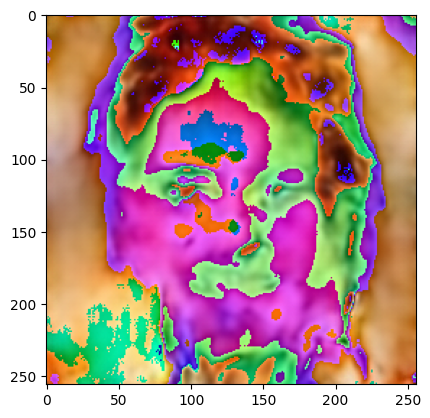

100%|██████████| 6750/6750 [27:08<00:00,  4.14it/s]


Finished epoch:2 | Loss : 0.1681


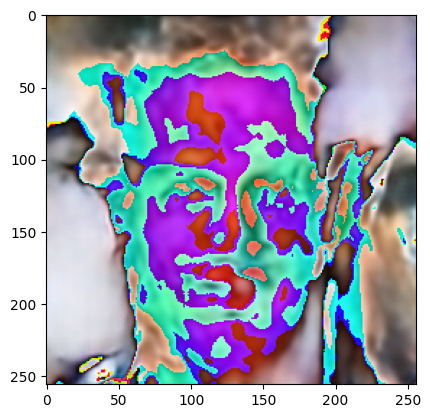

100%|██████████| 6750/6750 [27:25<00:00,  4.10it/s]


Finished epoch:3 | Loss : 0.1581


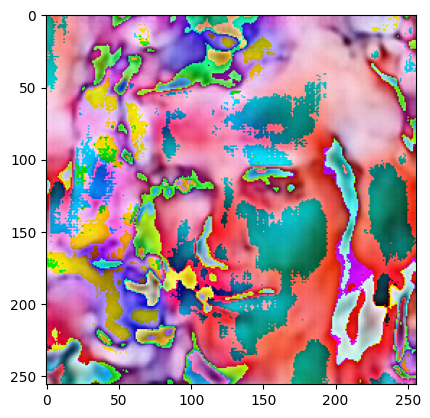

100%|██████████| 6750/6750 [27:14<00:00,  4.13it/s]


Finished epoch:4 | Loss : 0.1518


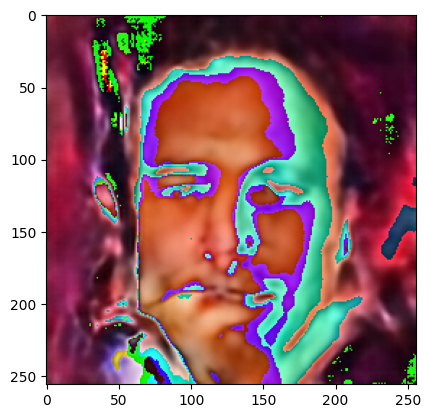

100%|██████████| 6750/6750 [26:50<00:00,  4.19it/s]


Finished epoch:5 | Loss : 0.1471


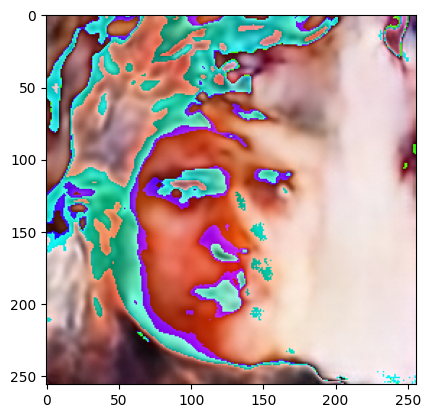

In [11]:
vqvae=VQVAE()
for param in vqvae.parameters():
    param.requires_grad = False
# diffusion=UNET()
assert os.path.exists(hp.vqvae_ckpt),"Model weights Needed to Proceed"
if  os.path.exists(hp.vqvae_ckpt):
    vqvae.load_state_dict(torch.load(hp.vqvae_ckpt,map_location=device))
    print('Model Weights Loaded')
else:
    print('Model weights Not Loaded')

# Load helper objects
scheduler=LinearNoiseScheduler(num_timesteps=hp.num_timesteps,
                               beta_start=hp.beta_start,beta_end=hp.beta_end)

optimizer=optim.Adam(diffusion.parameters(),lr=hp.lr)

train(diffusion,vqvae,train_dl,optimizer,scheduler,device)